<center>

<table><tr><td><img src='./img/sber.jpg' width='300'></td><td><img src='./img/ods.jpg' width='300'></td><td><img src='./img/quantopian.jpg' width='300'></td></tr></table>

</center>



<center>
    
# Часть 3. Эконометрический подход

**Авторы материала:** Денис Димитров, Дмитрий Сергеев, Андрей Кириленко. Материал можно использовать в любых целях (редактировать, поправлять и брать за основу), но с обязательным упоминанием авторов материала.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

### Стационарность

Перед тем, как перейти к моделированию, стоит сказать о таком важном свойстве временного ряда, как [**стационарность**](https://ru.wikipedia.org/wiki/Стационарность). 
Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями). Наглядно можно посмотреть на эти свойства на картинках, взятых из поста [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

- Временной ряд справа не является стационарным, так как его матожидание со временем растёт

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Здесь не повезло с дисперсией - разброс значений ряда существенно варьируется в зависимости от периода

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Наконец, на последнем графике видно, что значения ряда внезапно становятся ближе друг ко другу, образуя некоторый кластер, а в результате получаем непостоянство ковариаций

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределами учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Чтобы бороться с нестационарностью, нужно узнать её в лицо, потому посмотрим, как её детектировать. Для этого обратимся к белому шуму и случайному блужданию.

График белого шума:

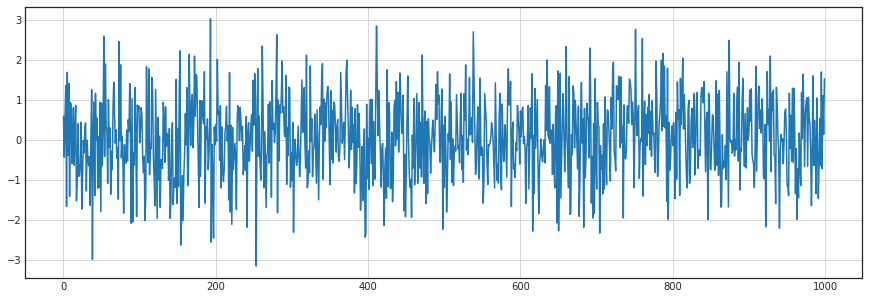

In [2]:
white_noise = np.random.normal(size=1000)
# bmh
with plt.style.context('seaborn-white'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)
    plt.grid(True)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$

Код для отрисовки графиков

In [3]:
x = w = np.random.normal(size=1000)

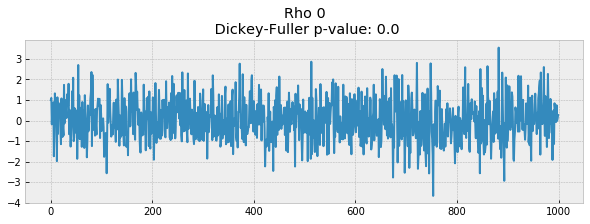

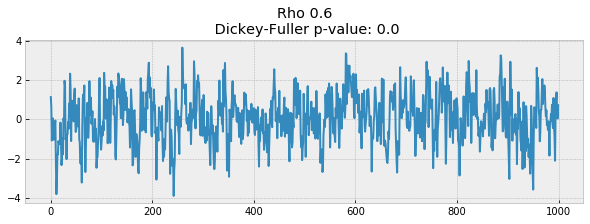

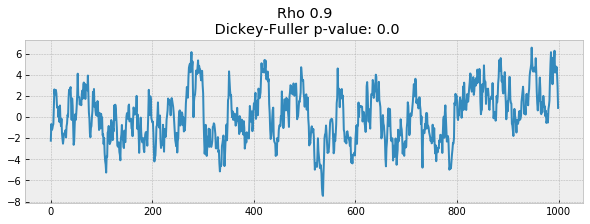

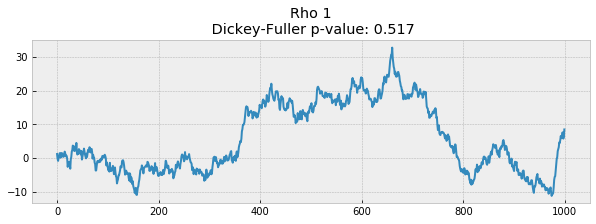

In [4]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания - ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева - первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера) на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка.
Нулевая гипотеза - ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

Бороться с нестационарностью можно множеством способов - разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## Избавляемся от нестационарности и строим SARIMA

In [5]:
dataset = pd.read_csv('./data/lecture1/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

Код для отрисовки графиков

In [6]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.190189


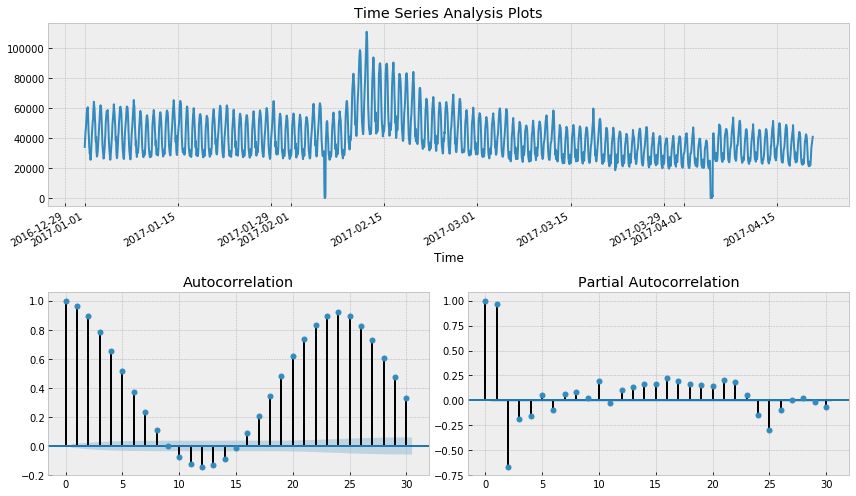

In [7]:
tsplot(dataset.Users, lags=30)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

Критерий Дики-Фуллера: p=0.079760
Оптимальный параметр преобразования Бокса-Кокса: 0.587270


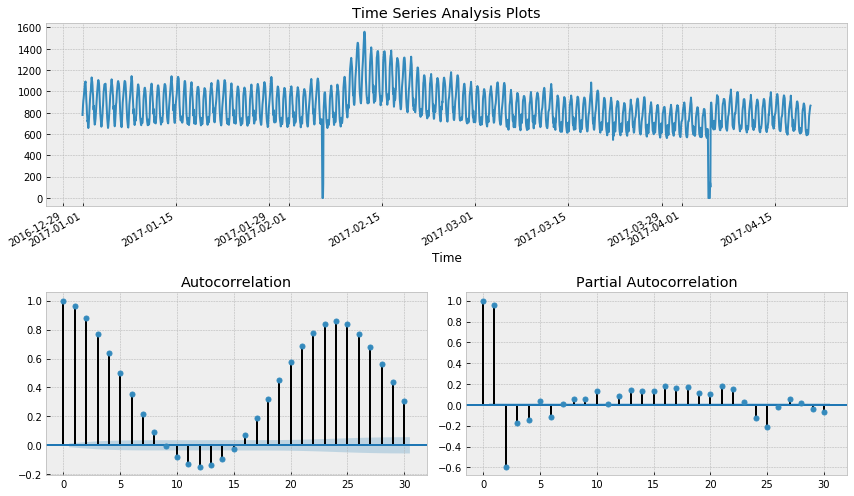

In [8]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = dataset.copy()
data['Users_box'], lmbda = scs.boxcox(data.Users+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

Критерий Дики-Фуллера: p=0.002571


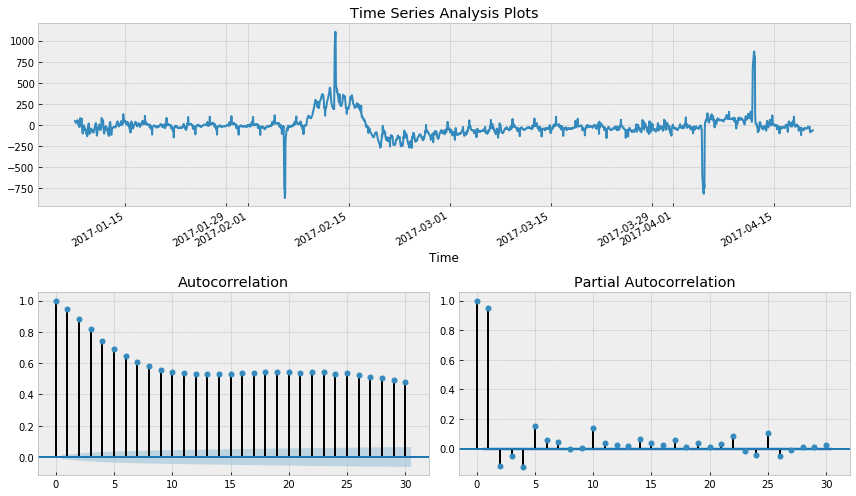

In [9]:
data['Users_box_season'] = data.Users_box - data.Users_box.shift(24*7)
tsplot(data.Users_box_season[24*7:], lags=30)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности, но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.000000


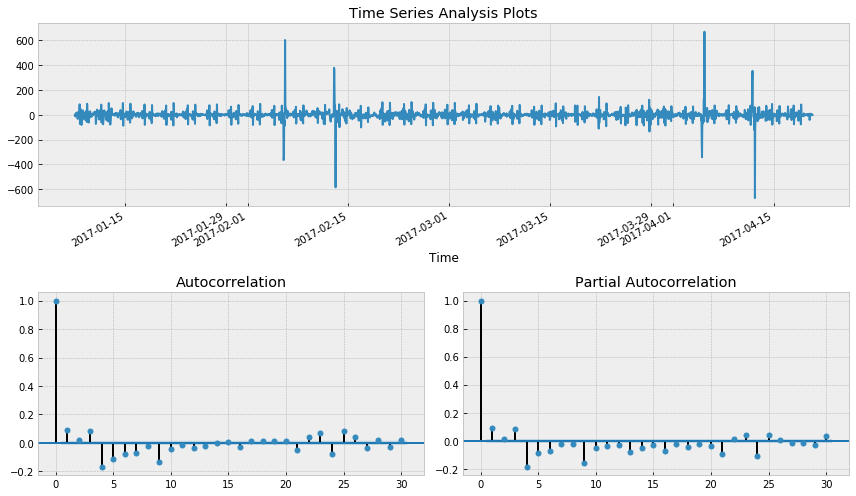

In [10]:
data['Users_box_season_diff'] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[24*7+1:], lags=30)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [11]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Users_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

CPU times: user 43min 16s, sys: 7min 58s, total: 51min 15s
Wall time: 17min 4s


Лучшие параметры загоняем в модель:

In [13]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data.Users_box, order=(4, d, 3), 
                                        seasonal_order=(4, D, 1, 24)).fit(disp=-1)

/Users/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/user/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 59min 3s, sys: 6min 47s, total: 1h 5min 50s
Wall time: 17min 46s


In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Users_box   No. Observations:                 2625
Model:             SARIMAX(4, 1, 3)x(4, 1, 1, 24)   Log Likelihood              -12550.915
Date:                            Tue, 08 Dec 2020   AIC                          25127.829
Time:                                    05:22:34   BIC                          25204.052
Sample:                                         0   HQIC                         25155.446
                                           - 2625                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2251      0.206      5.938      0.000       0.821       1.629
ar.L2         -0.7076      0.314   

Критерий Дики-Фуллера: p=0.000000


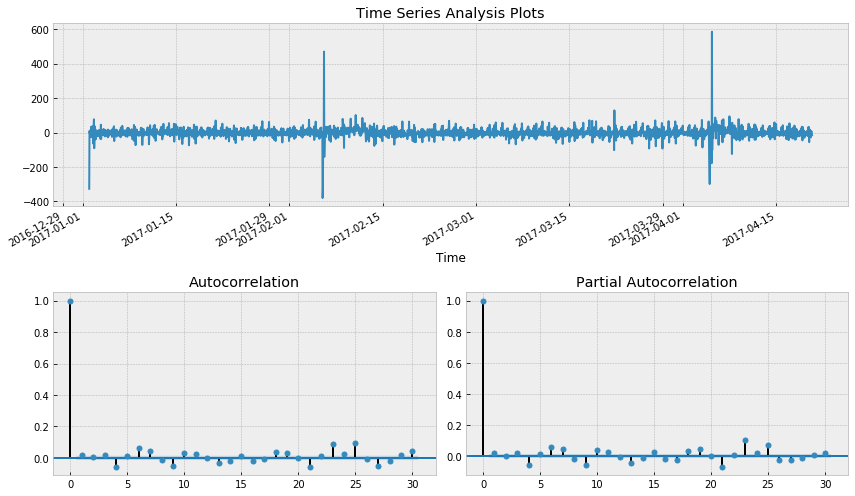

In [15]:
tsplot(best_model.resid[24:], lags=30)

Что ж, остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

/Users/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log

/Users/user/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



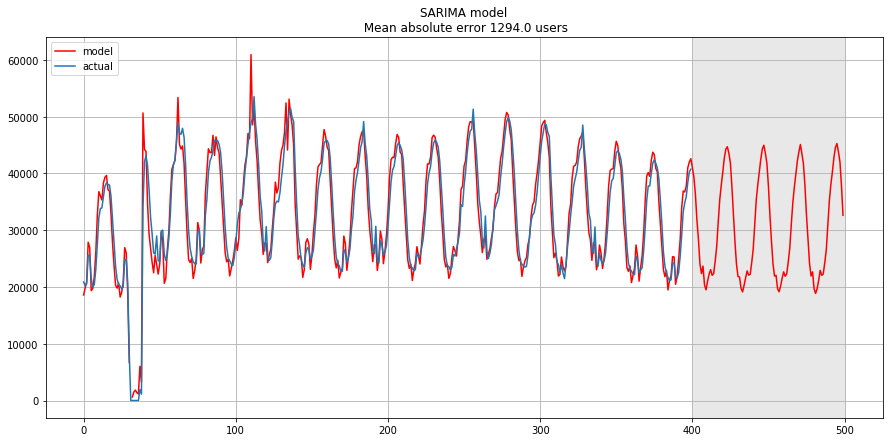

In [16]:
data['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

В финале получаем достаточно адекватный прогноз, в среднем модель ошибалась на 1.3 K пользователей, что очень и очень неплохо, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.

## Simulating a GARCH(1, 1) Case

In [17]:
import cvxopt
from functools import partial
import math
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt

We'll start by using Monte Carlo sampling to simulate a GARCH(1, 1) process. Our dynamics will be

$$\sigma_1 = \sqrt{\frac{a_0}{1-a_1-b_1}} \\
\sigma_t^2 = a_0 + a_1 x_{t-1}^2+b_1 \sigma_{t-1}^2 \\
x_t = \sigma_t \epsilon_t \\
\epsilon \sim \mathcal{N}(0, 1)$$

Our parameters will be $a_0 = 1$, $a_1=0.1$, and $b_1=0.8$. We will drop the first 10% (burn-in) of our simulated values.

In [18]:
# Define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [19]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return X, sigma

Now we'll compare the tails of the GARCH(1, 1) process with normally distributed values. We expect to see fatter tails, as the GARCH(1, 1) process will experience extreme values more often.

In [20]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in
X = X / np.std(X) # Normalize X

def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[1.61111111e-01, 2.27777778e-02, 2.33333333e-03, 2.22222222e-04],
       [1.58655254e-01, 2.27501319e-02, 1.34989803e-03, 3.16712418e-05]])

Sure enough, the tails of the GARCH(1, 1) process are fatter. We can also look at this graphically, although it's a little tricky to see.

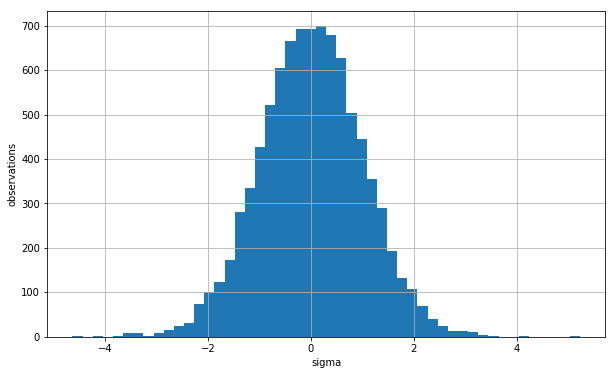

In [21]:
plt.figure(figsize=(10,6))
plt.hist(X, bins=50)
plt.xlabel('sigma')
plt.ylabel('observations');
plt.grid(True)

In [22]:
# Sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X, X2])

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.



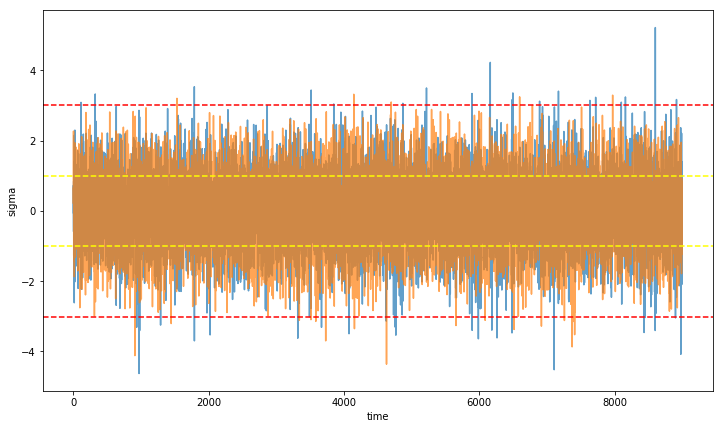

In [23]:
# Plot both the GARCH and normal values
plt.figure(figsize=(12,7))
plt.plot(facecolor='white')
plt.plot(both.T, alpha=.7);
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma');

What we're looking at here is the GARCH process in blue and the normal process in green. The 1 and 3 std bars are drawn on the plot. We can see that the blue GARCH process tends to cross the 3 std bar much more often than the green normal one.

## Testing for ARCH Behavior
The first step is to test for ARCH conditions. To do this we run a regression on $x_t$ fitting the following model.

$$x_t^2 = a_0 + a_1 x_{t-1}^2 + \dots + a_p x_{t-p}^2$$

We use OLS to estimate $\hat\theta = (\hat a_0, \hat a_1, \dots, \hat a_p)$ and the covariance matrix $\hat\Omega$. We can then compute the test statistic

$$F = \hat\theta \hat\Omega^{-1} \hat\theta'$$

We will reject if $F$ is greater than the 95% confidence bars in the $\mathcal(X)^2(p)$ distribution.

To test, we'll set $p=20$ and see what we get.

(20, 1)
F = 358.8881470270468
p-value = 0.0
[[ 34.72376577  -5.51559913  39.93370128  14.57793923   6.09595717
   13.56833068  -5.75423957  18.27473547  32.92399135 -18.53183781
    5.97867467  26.74738572  21.08605356   9.96352683  46.99478132
    8.62847341 -37.48513001  16.12702971  17.77582599  24.66724821]]


/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/Users/user/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/Users/user/anaconda3/li

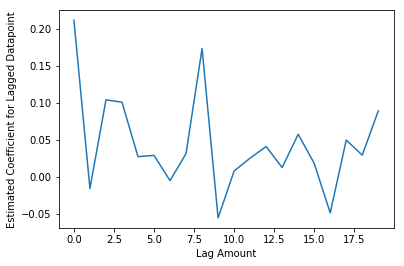

In [24]:
X, _ = simulate_GARCH(1100, a0, a1, b1, sigma1)
X = X[100:] # Drop burn in

p = 20

# Drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
X2 = np.ndarray((980, p))
for i in range(p, 1000):
    X2[i - p, :] = np.asarray((X**2)[i-p:i])[::-1]

model = sm.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = np.asscalar(theta * np.linalg.inv(omega) * theta.T)

print(np.asarray(theta.T).shape)

plt.plot(range(20), np.asarray(theta.T))
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

print('F = ' + str(F))

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print('p-value = ' + str(pvalue))

# Finally let's look at the significance of each a_p as measured by the standard deviations away from 0
print(theta/np.diag(omega))

## Fitting GARCH(1, 1) with MLE
Once we've decided that the data might have an underlying GARCH(1, 1) model, we would like to fit GARCH(1, 1) to the data by estimating parameters.

To do this we need the log-likelihood function

$$\mathcal{L}(\theta) = \sum_{t=1}^T - \ln \sqrt{2\pi} - \frac{x_t^2}{2\sigma_t^2} - \frac{1}{2}\ln(\sigma_t^2)$$

To evaluate this function we need $x_t$ and $\sigma_t$ for $1 \leq t \leq T$. We have $x_t$, but we need to compute $\sigma_t$. To do this we need to make a guess for $\sigma_1$. Our guess will be $\sigma_1^2 = \hat E[x_t^2]$. Once we have our initial guess we compute the rest of the $\sigma$'s using the equation

$$\sigma_t^2 = a_0 + a_1 x_{t-1}^2 + b_1\sigma_{t-1}^2$$

In [25]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in

In [26]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

Let's look at the sigmas we just generated.

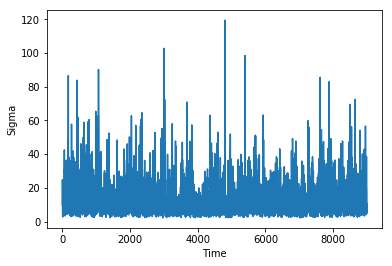

In [27]:
plt.plot(range(len(X)), compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma');

Now that we can compute the $\sigma_t$'s, we'll define the actual log likelihood function. This function will take as input our observations $x$ and $\theta$ and return $-\mathcal{L}(\theta)$. It is important to note that we return the negative log likelihood, as this way our numerical optimizer can minimize the function while maximizing the log likelihood.

Note that we are constantly re-computing the $\sigma_t$'s in this function.

In [28]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

Now we perform numerical optimization to find our estimate for
$$\hat\theta = \arg \max_{(a_0, a_1, b_1)}\mathcal{L}(\theta) = \arg \min_{(a_0, a_1, b_1)}-\mathcal{L}(\theta)$$

We have some constraints on this

$$a_1 \geq 0, b_1 \geq 0, a_1+b_1 < 1$$

In [29]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log



theta MLE: [0.94298931 0.09420595 0.81128611]


Now we would like a way to check our estimate. We'll look at two things:

1. How fat are the tails of the residuals.
2. How normal are the residuals under the Jarque-Bera normality test.

We'll do both in our `check_theta_estimate` function.

In [30]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print('Tails table')
    print(compare_tails_to_normal(epsilon / np.std(epsilon)))
    print('')
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print('Jarque-Bera probability normal: ' + str(pvalue))
    
check_theta_estimate(X, theta_mle)

Tails table
[[1.61777778e-01 2.30000000e-02 1.44444444e-03 1.11111111e-04]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]

Jarque-Bera probability normal: 0.0884584442210797


## GMM for Estimating GARCH(1, 1) Parameters
We've just computed an estimate using MLE, but we can also use Generalized Method of Moments (GMM) to estimate the GARCH(1, 1) parameters.

To do this we need to define our moments. We'll use 4.

1. The residual $\hat\epsilon_t = x_t / \hat\sigma_t$
2. The variance of the residual $\hat\epsilon_t^2$
3. The skew moment $\mu_3/\hat\sigma_t^3 = (\hat\epsilon_t - E[\hat\epsilon_t])^3 / \hat\sigma_t^3$
4. The kurtosis moment $\mu_4/\hat\sigma_t^4 = (\hat\epsilon_t - E[\hat\epsilon_t])^4 / \hat\sigma_t^4$

In [31]:
# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

GMM now has three steps.

Start with $W$ as the identity matrix.

1. Estimate $\hat\theta_1$ by using numerical optimization to minimize

$$\min_{\theta \in \Theta} \left(\frac{1}{T} \sum_{t=1}^T g(x_t, \hat\theta)\right)' W \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta)\right)$$

2. Recompute $W$ based on the covariances of the estimated $\theta$. (Focus more on parameters with explanatory power)

$$\hat W_{i+1} = \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta_i)g(x_t, \hat\theta_i)'\right)^{-1}$$

3. Repeat until $|\hat\theta_{i+1} - \hat\theta_i| < \epsilon$ or we reach an iteration threshold.

Initialize $W$ and $T$ and define the objective function we need to minimize.

In [32]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

Now we're ready to the do the iterated minimization step.

In [33]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print('Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate))
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))
    

check_theta_estimate(X, theta_gmm_estimate)

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



Iteration 0 theta: [1.12591901 0.02485414 0.85945984]


/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: PendingDeprecationWarning:

the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.



Iteration 1 theta: [1.12587085 0.02474576 0.85898852]
Iteration 2 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 3 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 4 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 5 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 6 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 7 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 8 theta: [1.12587053 0.02474248 0.8589854 ]
Iteration 9 theta: [1.12587053 0.02474248 0.8589854 ]
Tails table
[[1.61333333e-01 2.22222222e-02 2.44444444e-03 1.11111111e-04]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]

Jarque-Bera probability normal: 0.5095893667022054


## Predicting the Future: How to actually use what we've done
Now that we've fitted a model to our observations, we'd like to be able to predict what the future volatility will look like. To do this, we can just simulate more values using our original GARCH dynamics and the estimated parameters.

The first thing we'll do is compute an initial $\sigma_t$. We'll compute our squared sigmas and take the last one.

In [34]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

2.8999267289579307

Now we'll just sample values walking forward.

In [35]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

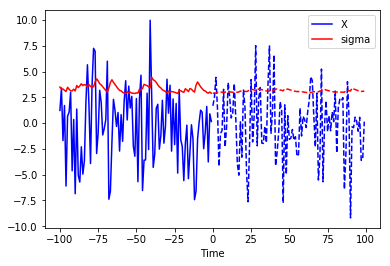

In [36]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma']);

One should note that because we are moving foward using a random walk, this analysis is supposed to give us a sense of the magnitude of sigma and therefore the risk we could face. It is not supposed to accurately model future values of X. In practice you would probably want to use Monte Carlo sampling to generate thousands of future scenarios, and then look at the potential range of outputs. We'll try that now. Keep in mind that this is a fairly simplistic way of doing this analysis, and that better techniques, such as Bayesian cones, exist.

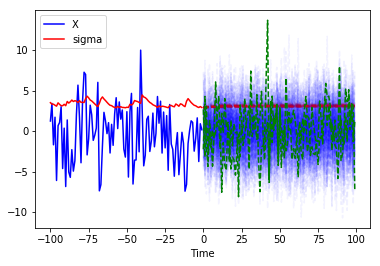

In [37]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])


max_X = [-np.inf]
min_X = [np.inf]
for i in range(100):
    X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
    if max(X_forecast) > max(max_X):
        max_X = X_forecast
    elif min(X_forecast) < min(max_X):
        min_X = X_forecast
    plt.plot(range(0, 100), X_forecast, 'b--', alpha=0.05)
    plt.plot(range(0, 100), sigma_forecast, 'r--', alpha=0.05)

# Draw the most extreme X values specially
plt.plot(range(0, 100), max_X, 'g--', alpha=1.0)
plt.plot(range(0, 100), min_X, 'g--', alpha=1.0);